In [1]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger # Comment out if not using wandb
from pytorch_lightning.callbacks import TQDMProgressBar
from pytorch_lightning.callbacks import StochasticWeightAveraging
import torch
# torch.multiprocessing.set_start_method('spawn', force=True)
from q2l_labeller.data.coco_data_module import COCODataModule
from q2l_labeller.pl_modules.query2label_train_module import Query2LabelTrainModule
from q2l_labeller.data.dataset import SeaThruAugmentation
pl.seed_everything(50)
torch.backends.cudnn.benchmark = True

param_dict = {
    "backbone_desc":"resnet50.a1_in1k",
    "conv_out_dim":2048,
    "hidden_dim":256,
    "num_encoders":2,
    "num_decoders":3,
    "num_heads":8,
    "batch_size":128,
    "image_dim":384,
    "learning_rate":1e-4,
    "momentum":0.9,
    "weight_decay":0.01,
    "n_classes":290,
    "thresh":0.5,
    "use_cutmix":True,
    "use_seathru":True,
    "use_pos_encoding":True,
    "loss":"ASL",
}

# train_classes = [160, 51, 119, 37, 52, 10, 88, 146, 125, 1, 260, 133, 9, 214, 70, 120, 111, 142, 274, 105, 69, 174, 203, 103, 228, 259, 205, 104, 116, 242, 16, 219, 81, 61, 100, 11, 224, 202, 82, 108, 255, 3, 54, 162, 85, 256, 8, 67, 71, 75, 173, 201, 93, 243, 218, 131, 99, 43, 36, 283]

image_folder = '/home/mundus/mrahman528/projects/mir/depth_jitter/fathomnet_2023_dataset'
depth_image_folder = '/home/mundus/mrahman528/projects/mir/depth_jitter/fathomnet_2023_dataset/depth_vis_train'
depth_npy_folder = '/home/mundus/mrahman528/projects/mir/depth_jitter/fathomnet_2023_dataset/depth_vis_train'
seathru_parameters_path = '/home/mundus/mrahman528/Depth-Jitter/parameters_train.json'
seathru_transform = SeaThruAugmentation(image_folder, depth_image_folder, depth_npy_folder, seathru_parameters_path)

coco = COCODataModule(
    data_dir="/home/mundus/mrahman528/projects/mir/depth_jitter/fathomnet_2023_dataset",
    img_size=384,
    batch_size=128,
    num_workers=16,  # Adjust based on CPU cores
    use_cutmix=True,
    cutmix_alpha=1.0,
    train_classes=None,
    augmentation_strategy="seathru",
    seathru_transform=seathru_transform
)

param_dict["data"] = coco

# pl_model = Query2LabelTrainModule(**param_dict)

[rank: 0] Seed set to 50


In [2]:
pl_model = Query2LabelTrainModule(**param_dict)
if hasattr(pl_model, "backbone"):
    pl_model.backbone.freeze_backbone()


In [3]:
# Comment out if not using wandb
# wandb_logger = WandbLogger(
#     project="fathomnet_osd", 
#     save_dir="training/logs/fathomnet_with_all_seathru",
#     log_model=True)
# wandb_logger.watch(pl_model, log="all")

trainer = pl.Trainer(
    max_epochs=1,
    precision=16,
    accelerator='gpu', 
    devices='auto',  # Use all available GPUs
    # strategy='ddp',  # Use Distributed Data Parallel strategy
    gradient_clip_val=0.5,  # Gradient clipping
    # logger=wandb_logger, # Comment out if not using wandb
    default_root_dir="training/checkpoints/depth_jitter",
    callbacks=[TQDMProgressBar(refresh_rate=100)],  # Reduce logging frequency
    # profiler="simple"  # Profile to identify bottlenecks
)
trainer.fit(pl_model, param_dict["data"])

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A40') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2024-12-24 00:10:50.329154: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-24 00:10:51.570146: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


loading annotations into memory...
Done (t=0.08s)
creating index...
index created!
Seathru Transform Initialized: True
loading annotations into memory...
Done (t=0.02s)
creating index...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


index created!
Seathru Transform Initialized: True



  | Name           | Type           | Params
--------------------------------------------------
0 | model          | Query2Label    | 53.0 M
1 | base_criterion | AsymmetricLoss | 0     
--------------------------------------------------
53.0 M    Trainable params
0         Non-trainable params
53.0 M    Total params
212.017   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=1` reached.


Augmented image shape: torch.Size([3, 384, 384])
Augmentation time: 0.1197 seconds


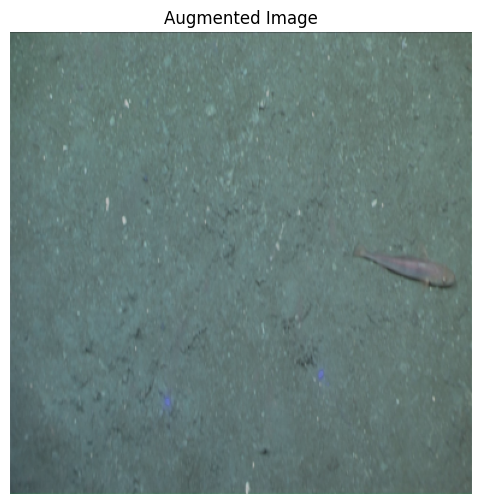

In [53]:
import time
import cv2
# Test a single pass through the augmentation
start_time = time.time()
# Example: Use an image
image_name = "0eaa30d8-b338-4faf-8132-6b1637cd27cc.png"  # The name of your image file
image_path = f"/home/mundus/mrahman528/projects/mir/depth_jitter/fathomnet_2023_dataset/val/{image_name}"
image = cv2.imread(image_path)

# Apply augmentation
try:
    augmented_image = seathru_transform(image_name, image)
    print(f"Augmented image shape: {augmented_image.shape}")
except FileNotFoundError as e:
    print(f"Error: {e}")
# augmented_sample = seathru_transform(im)  # Replace image_sample with a test image
print(f"Augmentation time: {time.time() - start_time:.4f} seconds")

import matplotlib.pyplot as plt
import torch

# Assuming `augmented_image` is the tensor from your augmentation pipeline
# Convert the PyTorch tensor to a NumPy array
augmented_image_np = augmented_image.permute(1, 2, 0).numpy()  # Change shape from (C, H, W) to (H, W, C)

# The image may be normalized; undo the normalization if necessary
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
# augmented_image_np = (augmented_image_np)  # Denormalize
augmented_image_np = augmented_image_np.clip(0, 1)  # Ensure pixel values are in [0, 1]

# Plot the image
plt.figure(figsize=(6, 6))
plt.imshow(augmented_image_np)
plt.axis('off')  # Hide axes for better visualization
plt.title("Augmented Image")
plt.show()
